In [19]:
'''An implementation of the stochastic ensemble kalman filter without the explicit Kalman gain 
and the perturbed measurements coming from a poisson distribution. '''

import numpy as np 
import matplotlib.pyplot as plt

'''Tau leaping model so we have some stochasticity. '''

days = 100
delta_t = 0.1 
rng = np.random.default_rng(0)

def model(theta,rng,*,days,delta_t): 
    beta,gamma = theta

    S = np.zeros(days * int(1/delta_t))
    I = np.zeros(days * int(1/delta_t))
    R = np.zeros(days * int(1/delta_t))

    SI = np.zeros(days * int(1/delta_t))
    IR = np.zeros(days * int(1/delta_t))

    #Initial condition
    S[0] = 1000
    I[0] = 5
    R[0] = 0

    N = S[0] + I[0] + R[0]

    for t in range(1,int(1/delta_t) * days): 

        #Rate equations
        dN_SI = rng.poisson(beta * (S[t-1] * I[t-1]/N) * delta_t)
        dN_IR = rng.poisson(I[t-1] * gamma * delta_t)

        SI[t] = dN_SI
        IR[t] = dN_IR

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return (S,I,R,SI,IR) 

theta = (0.3,0.1) #Real parameters
S,I,R,SI,IR = model(theta,rng,days = days,delta_t = delta_t)

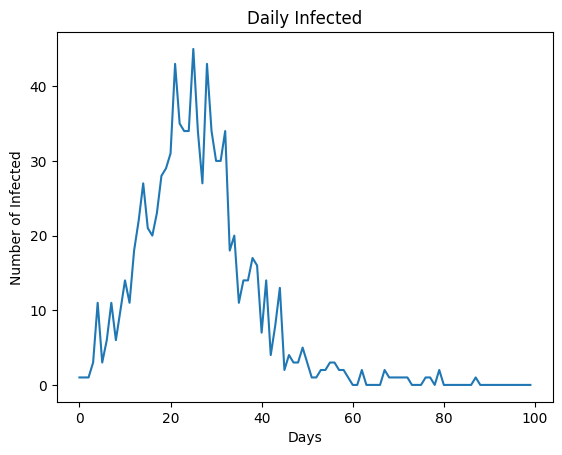

In [20]:
#Extract the data daily
data_real = SI.reshape((days,int(1/delta_t))).sum(axis = 1)

plt.title('Daily Infected')
plt.xlabel('Days')
plt.ylabel('Number of Infected')
plt.plot(np.arange(0,days,1),data_real)

In [21]:
def single_step(theta,state,rng,*,delta_t,log = False): 
    beta,gamma = theta
    if log: 
        beta = np.exp(beta)
        gamma = np.exp(gamma)

    S0,I0,R0,_,_ = state

    S = np.zeros(int(1/delta_t))
    I = np.zeros(int(1/delta_t))
    R = np.zeros(int(1/delta_t))

    SI = np.zeros(int(1/delta_t))
    IR = np.zeros(int(1/delta_t))


    S[0] = S0
    I[0] = I0
    R[0] = R0

    N = S0 + I0 + R0

    for t in range(1,int(1/delta_t)): 

        #Rate equations
        dN_SI = rng.poisson(max(beta * (S[t-1] * I[t-1]/N) * delta_t,0.))
        dN_SI = min(dN_SI,S[t-1])

        dN_IR = rng.poisson(max(I[t-1] * gamma * delta_t,0.))
        dN_IR = min(dN_IR,I[t-1])

        SI[t] = dN_SI
        IR[t] = dN_IR

        S[t] = S[t-1] - dN_SI
        I[t] = I[t-1] + dN_SI - dN_IR
        R[t] = R[t-1] + dN_IR

    return np.array([S[-1],I[-1],R[-1],SI.sum(),IR.sum()]).squeeze()

In [22]:
H = np.array([0.,0.,0.,1.,0.]) #Observation operator
num_ensemble_members = 10
members = np.full((num_ensemble_members,5),np.array([1000,5,0,0,0])) #Initialize the particles with the correct I.C.
R = 100.

ensemble_mean = np.zeros((len(data_real),5))
ensemble_cov = np.zeros((len(data_real),5,5))

for index,observation in enumerate(data_real): 
    observation = np.array([observation])

    if index > 0: 
        for member_index in range(num_ensemble_members): 
            members[member_index,...] = single_step((0.3,0.1),members[member_index,...],rng,delta_t = 0.1)

    #Analysis
    mean = np.mean(members,axis = 0)
    state_perturbation_matrix = 1/np.sqrt(num_ensemble_members - 1) * (members - mean)

    obs_mean = mean[3]
    obs_perturbation_matrix = 1/np.sqrt(num_ensemble_members - 1) * (members[:,3] - obs_mean)

    cross_cov = state_perturbation_matrix.T @ obs_perturbation_matrix.T
    cross_cov = cross_cov[:,np.newaxis]

    S = obs_perturbation_matrix[:,np.newaxis].T @ obs_perturbation_matrix[:,np.newaxis]

    perturbed_observations = np.full((num_ensemble_members,len(observation)),observation)
    perturbed_observations = rng.poisson(perturbed_observations)


    S_inv = np.linalg.pinv(S)
    for member_index in range(num_ensemble_members): 
        innovation = perturbed_observations[member_index] - members[member_index,3]
        alpha = S_inv @ innovation

        members[member_index,...] = members[member_index,...] + cross_cov @ alpha

    #Statistics
    ensemble_mean[index,...] = np.mean(members,axis = 0)
    ensemble_cov[index,...] = np.cov(members.T)

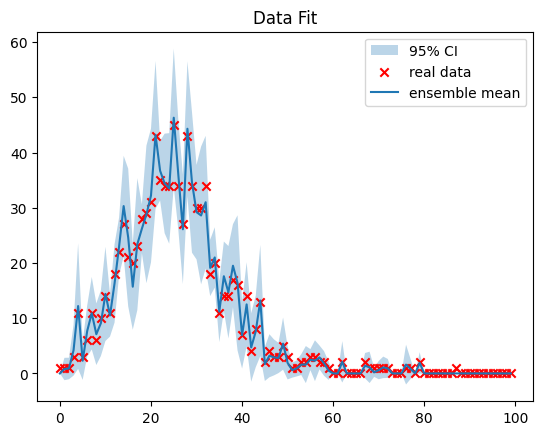

In [23]:
std_SI = np.sqrt(ensemble_cov[:,3,3])

lower = ensemble_mean[:,3] - 1.96 * std_SI
upper = ensemble_mean[:,3] + 1.96 * std_SI

plt.title('Data Fit')
plt.fill_between(np.arange(0,days,1),lower,upper,alpha = 0.3,label = '95% CI')
plt.scatter(np.arange(0,days,1),data_real,marker = 'x', color = 'red',label = 'real data')
plt.plot(np.arange(0,days,1),ensemble_mean[:,3],label = 'ensemble mean')
plt.legend()

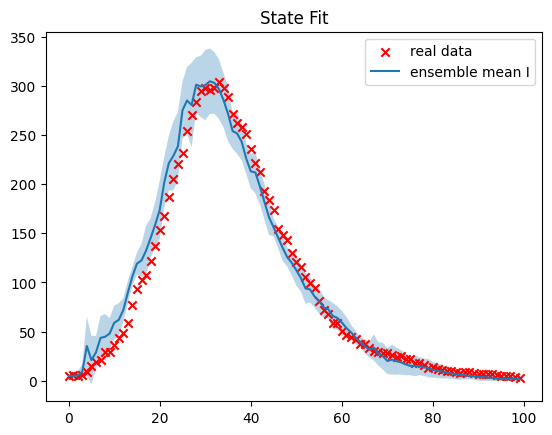

In [24]:
std_I = np.sqrt(ensemble_cov[:,1,1])

lower = ensemble_mean[:,1] - 1.96 * std_I
upper = ensemble_mean[:,1] + 1.96 * std_I

plt.title('State Fit')
plt.fill_between(np.arange(0,days,1),lower,upper,alpha = 0.3)
plt.scatter(np.arange(0,days,1),I[::int(1/delta_t)],marker = 'x', color = 'red',label = 'real data')
plt.plot(np.arange(0,days,1),ensemble_mean[:,1],label = 'ensemble mean I')
plt.legend()